In [1]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate = pd.Timedelta(1, unit = 'm')
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step, starting_time, time_to_simulate)

simulator.add_simulation(config_dir, results_dir)

simulator.start_simulation()

6001it [00:05, 1161.89it/s]                                                                                            


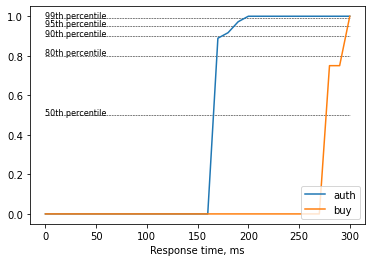

<Figure size 432x288 with 0 Axes>

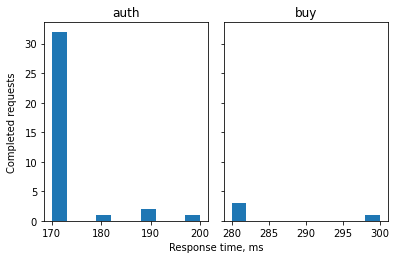

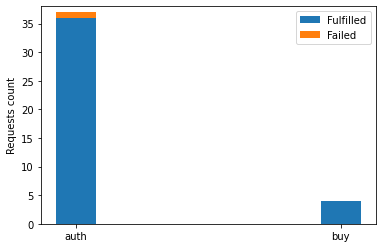

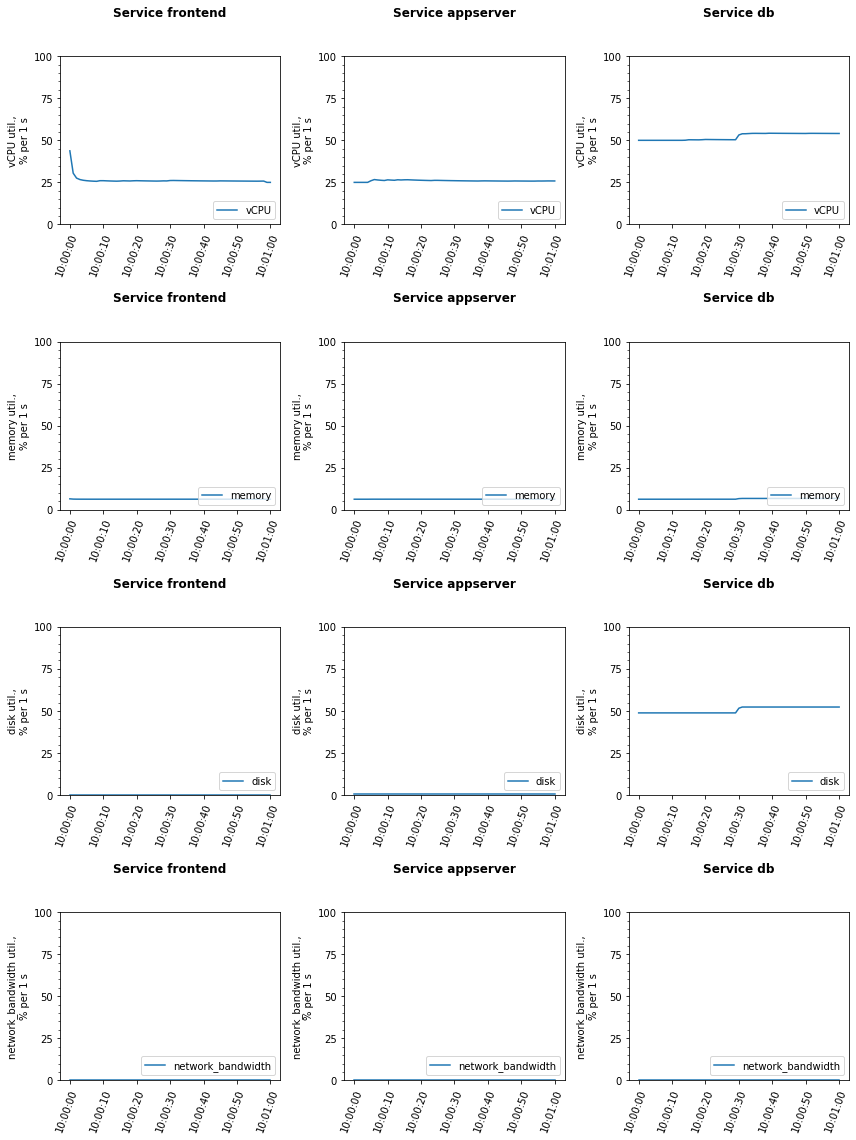

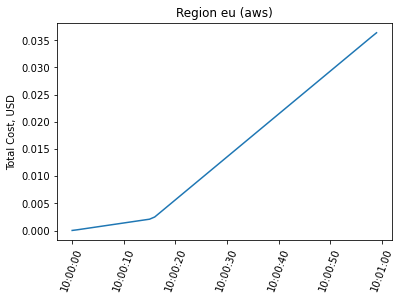

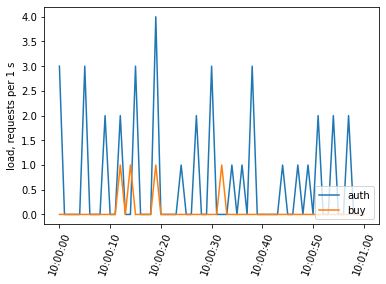

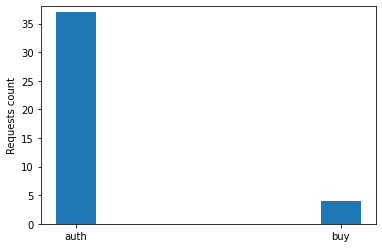

<Figure size 432x288 with 0 Axes>

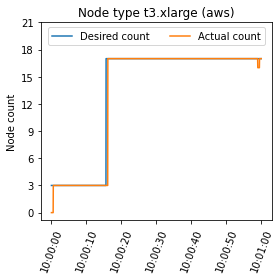

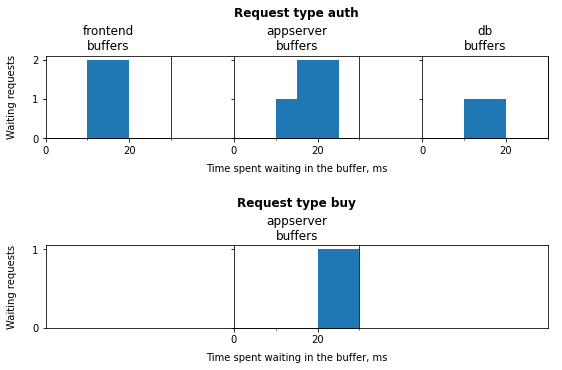

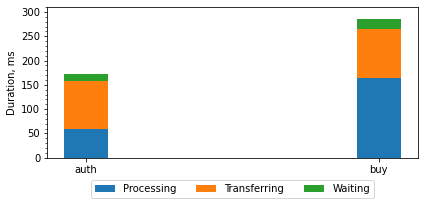

In [2]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')

In [114]:
import os

def file_id_to_str(file_id : int):
    return '0' + str(file_id) if file_id < 10 else str(file_id)
    
file_ids = range(1, 12)

data_path = "D:\\@TUM\\PhD\\FINAL\\traces\\azurefunctions\\"
filename_pattern_invocations = "invocations_per_function_md.anon.d{}.csv"
filename_pattern_memory = "app_memory_percentiles.anon.d{}.csv"
filename_pattern_duration = "function_durations_percentiles.anon.d{}.csv"

cur_file_id = file_id_to_str(list(file_ids)[0])
cur_filename_invocations = os.path.join(data_path, filename_pattern_invocations.format(cur_file_id))
cur_filename_memory = os.path.join(data_path, filename_pattern_memory.format(cur_file_id))
cur_filename_duration = os.path.join(data_path, filename_pattern_duration.format(cur_file_id))

invocations_data = pd.read_csv(cur_filename_invocations)
memory_data = pd.read_csv(cur_filename_memory)
duration_data = pd.read_csv(cur_filename_duration)

In [253]:
#selected_app_id = '1900c1fc4c4a60bff0467f4a22b21708fe182989977a7df4f82420ea75fdec84'

invocations_data_http = invocations_data[data.Trigger == 'http']
invocations_data_http_melted = pd.melt(invocations_data_http, id_vars = ['HashApp', 'HashFunction'], value_vars = invocations_data_http.columns[4:]).rename(columns = {"variable": "datetime", "value": "invocations"})
invocations_data_http_melted.datetime = pd.to_datetime(invocations_data_http_melted.datetime, unit = 'm')
invocations_data_http_melted.set_index(["HashApp", "HashFunction", "datetime"], inplace = True)
invocations_data_http_melted_per_app = invocations_data_http_melted.groupby(["HashApp", "datetime"]).max()
invocations_data_http_melted_per_hour = invocations_data_http_melted_per_app.groupby(["HashApp", pd.Grouper(freq='60T', level="datetime")]).sum().fillna(0).rename(columns = {"invocations": "Load"})
invocations_data_http_mean_per_day = invocations_data_http_melted_per_hour.groupby(["HashApp"]).mean()

# TODO: add load from other files as well

(array([2.806e+03, 4.990e+02, 2.630e+02, 2.050e+02, 1.600e+02, 1.200e+02,
        8.800e+01, 7.400e+01, 6.500e+01, 6.100e+01, 4.800e+01, 1.890e+02,
        4.400e+01, 4.900e+01, 6.300e+01, 4.800e+01, 2.600e+01, 3.300e+01,
        2.400e+01, 4.700e+01, 1.900e+01, 1.700e+01, 2.600e+01, 5.300e+01,
        9.000e+00, 1.100e+01, 2.400e+01, 1.300e+01, 2.800e+01, 2.100e+01,
        8.000e+00, 1.300e+01, 1.000e+01, 9.000e+00, 2.200e+01, 1.500e+01,
        1.200e+01, 1.000e+01, 6.000e+00, 1.000e+01, 8.000e+00, 7.000e+00,
        1.100e+01, 6.000e+00, 9.000e+00, 1.200e+01, 2.300e+01, 7.000e+00,
        1.600e+01, 7.000e+00, 2.000e+00, 8.000e+00, 7.000e+00, 5.000e+00,
        7.000e+00, 1.200e+01, 1.300e+01, 1.250e+02, 2.400e+01, 9.000e+00,
        9.000e+00, 6.000e+00, 9.000e+00, 6.000e+00, 5.000e+00, 6.000e+00,
        1.200e+01, 6.000e+00, 6.000e+00, 6.000e+00, 1.000e+00, 6.000e+00,
        7.000e+00, 2.000e+00, 7.000e+00, 6.000e+00, 4.000e+00, 5.000e+00,
        5.000e+00, 4.000e+00, 9.000e+0

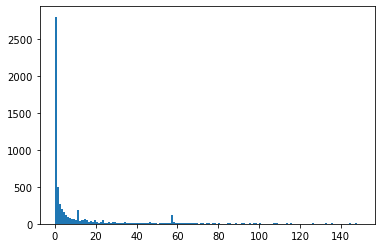

In [137]:
import matplotlib.pyplot as plt
plt.hist(invocations_data_http_mean_per_day.Load[invocations_data_http_mean_per_day.Load > 0], bins = range(0,150))

In [223]:
import collections 

begin_quantile = 0.7
end_quantile = 0.9

invocations_filtered = invocations_data_http_mean_per_day[invocations_data_http_mean_per_day.Load > 0]

begin_invocations = invocations_filtered.Load.quantile(begin_quantile)
end_invocations = invocations_filtered.Load.quantile(end_quantile)

apps_filtered_left = set(invocations_filtered[invocations_filtered.Load <= begin_invocations].index)
apps_filtered_right = set(invocations_filtered[invocations_filtered.Load <= end_invocations].index)

# TODO: cache the selection results on disk?
cached_results = dict()
cached_results[begin_quantile] = apps_filtered_left
cached_results[end_quantile] = apps_filtered_right - apps_filtered_left
cached_results

{0.7: {'9709dcce5a35eb852a34d6633225c3284bcaf608b6814736a2c7a784f5c67ad6',
  '222677d29452ccdfce5d1dd7fb8bdffeb6d5afcb8123be0d9852b5791e975c77',
  'ac1952f66c182e2be0946eae510abef41d30997c90f207c1157d2ec123ca5020',
  'f42223841ec0bbc8f077291aaaa63c023a0369c57bc9136f258f6de6bc325261',
  '903142a0540d281a0d23b42d47c77ec4051fb2c9a03b89d5386839c7cb7c53c0',
  'eacf4d2985504504f711fd642c2c5d9718831b16a38f055b925151efd85f5fbf',
  'f3174ea8284f88651be1658e9e971da7c7226990d3cb55588015f34fd2d76f32',
  'b87f1403269006cfb5d0783f74124e662755087b5b33ad9fa1d0093d0d814173',
  '5254bc568741dec26cde286479f0493afa5a243c4e3d5f47baf45266b6fbc730',
  '259778f70621f3bb70c4bf86b53dd7a641502aee40b7eaf207c13af0f6124f3f',
  'a25da24e0580abe6434da7e3d3b7ff880e536127b5efed8adcd5f32e7963f2a9',
  '31486fc64117f0962cbbe870c96fb0b216b201fbae5830ab330d40d5c101b5bd',
  '0ae34c7b346af70f46eaf2554e62f50ece21791f750b77a17b9d35a2e7c8221e',
  'f65065eb51382a457232e5539165574b3ef3bbf93cb8b10cdaefa52887bb4020',
  '802558c6df66

In [228]:
# TODO: Load percentiles from disk

begin_quantile = 0.8
end_quantile = 0.95

cached_results = collections.OrderedDict(sorted(cached_results.items(), key = lambda el: el[0]))

apps_filtered_left = set()
if not begin_quantile in cached_results:
    begin_invocations = invocations_filtered.Load.quantile(begin_quantile)
    apps_filtered_left = set(invocations_filtered[invocations_filtered.Load <= begin_invocations].index)
    
apps_filtered_between = set()
if not end_quantile in cached_results:
    end_invocations = invocations_filtered.Load.quantile(end_quantile)
    apps_filtered_right = set(invocations_filtered[invocations_filtered.Load <= end_invocations].index)
    apps_filtered_between = apps_filtered_right - apps_filtered_left
    
for quantile, ids_set in cached_results.items():
    if quantile < begin_quantile and len(apps_filtered_left) > 0:
        apps_filtered_left -= ids_set
            
    elif quantile > begin_quantile and quantile < end_quantile and len(apps_filtered_between) > 0:
        apps_filtered_between -= ids_set
            
    elif quantile > end_quantile and len(apps_filtered_between) > 0:
        ids_set -= apps_filtered_between

if len(apps_filtered_left) > 0:
    cached_results[begin_quantile] = apps_filtered_left
    
if len(apps_filtered_between) > 0:
    cached_results[end_quantile] = apps_filtered_between
    
# TODO: store cached_results on disk

cached_results = collections.OrderedDict(sorted(cached_results.items(), key = lambda el: el[0]))
selected_apps = set()
for quantile, ids_set in cached_results.items():
    if quantile > begin_quantile and quantile <= end_quantile:
        selected_apps |= ids_set

print(selected_apps)

{'22a6e77fb3e468408a257b13e4202a9bbffcc102a6bcd6feaa5a272753971242', '3496bac45b589b02bfb048099f7a7563d93ae54b9f661e646a96e7c96c1161f3', '9024d8fec9ed3e6a9094f5cffb668cdade220e1530d9ba58eff74b7d5edf8780', '31669922ca80af63629d749c4102c8fb0bfa588dab684fb05fa38f19823f65f5', 'e06889f57b16a37751c62f72ff0ad423d92a12ea7834cc25dd1b791656ae4011', 'd51db6953c876a7e05dd5e9a7f7393a3b9f0b7b1fae0f997270fcf9c895a0d02', 'bc19d61c87056f63b473b0fab26ffa31b50487e77db6df38f9004364ce4555bc', 'fbd187918dfb3e57d2d67d656e7952e5e3756415ae0869060e3a60df1f3cea3f', '5ff12218fb73d2db2688d5e9dae9e2ec2418d97cc629a6253f756a8126aab4ef', '1d4dfaeb205b45e781af20b5323cac3027d76c5533fdd2da18e69cd06dd52217', 'ef94bde1d9cd291f799bdead0fcf781030ef00b89b4c214a102f8b1a6a118aea', '579edf5e8bb3e06f1a3c0c20f5eb7ccfac7deaade7af68d7bf1664383744d894', '4190599837c4857589bb7a7c80c6ee96b73dbdf8c5d8f80aea3bfdc6421895a7', '380a87b460ca95895b5c3f3893d211d43ceadd92d4eead03e5c18fb7de919201', '6757ff6c1b5e77ad3ae57ab60c43982e549c6c9ebdfba9

In [297]:
app_size_quantile = 0.9

invocations_data_http_selected = invocations_data_http_melted.loc[list(selected_apps)]
averaged_load_per_minute = invocations_data_http_selected.groupby(['datetime']).mean().round().astype({'invocations': 'int32'})
services_count = int(invocations_data_http_selected.reset_index().groupby(['HashApp'])['HashFunction'].nunique().quantile(app_size_quantile))

In [375]:
import random

memory_data_aggregated = memory_data.groupby(['HashApp']).mean()
memory_data_selected = memory_data_aggregated.reindex(list(selected_apps)).dropna()
memory_percentiles = memory_data_selected.mean()[2:]

memory_percentiles = tuple(zip([0] + list(memory_percentiles[:-1]), list(memory_percentiles)))
selected_bin_interval = random.choices(memory_percentiles, weights=(0.01, 0.04, 0.20, 0.25, 0.25, 0.20, 0.04, 0.01))[0]
memory_usage_by_request = random.uniform(selected_bin_interval[0], selected_bin_interval[1])
#duration_data

In [388]:
import random

# TODO: consider using information about the function? e.g. distribution over the functions
# we have to first select a function with its probabilities distribution...
duration_data_aggregated = duration_data.groupby(['HashApp']).mean()
duration_data_selected = duration_data_aggregated.reindex(list(selected_apps)).dropna()
duration_percentiles = duration_data_selected.mean()[5:]

duration_percentiles = tuple(zip([0] + list(duration_percentiles[:-1]), list(duration_percentiles)))
selected_bin_interval = random.choices(duration_percentiles, weights=(0.01, 0.24, 0.25, 0.25, 0.24, 0.01))[0]
processing_duration_by_request = random.uniform(selected_bin_interval[0], selected_bin_interval[1])
print(processing_duration_by_request)

2329.1864098734213


In [87]:
data_http = data[data.Trigger == 'http']
data_http_melted = pd.melt(data_http, id_vars = ['HashApp', 'HashFunction'], value_vars = data_http.columns[4:]).rename(columns = {"variable": "datetime", "value": "invocations"})
data_http_melted.datetime = pd.to_datetime(data_http_melted.datetime, unit = 'm')
data_http_melted.set_index(["HashApp", "HashFunction", "datetime"], inplace = True)
data_http_melted = data_http_melted.groupby(["HashApp", "datetime"]).max()
data_http_melted = data_http_melted.groupby(["HashApp", pd.Grouper(freq='60T', level="datetime")]).sum().fillna(0).rename(columns = {"invocations": "Load"})

In [88]:
data_orchestration = data[data.Trigger == 'orchestration']
data_orchestration_melted = pd.melt(data_orchestration, id_vars = ['HashApp', 'HashFunction'], value_vars = data_orchestration.columns[4:]).rename(columns = {"variable": "datetime", "value": "invocations"})
data_orchestration_melted.datetime = pd.to_datetime(data_orchestration_melted.datetime, unit = 'm')
data_orchestration_melted.set_index(["HashApp", "HashFunction", "datetime"], inplace = True)
data_orchestration_melted = data_orchestration_melted.groupby(["HashApp", pd.Grouper(freq='60T', level="datetime")]).sum().fillna(0).rename(columns = {"invocations" : "OrchestrationEvents"})

In [89]:
data_merged = pd.concat([data_http_melted, data_orchestration_melted], axis=1).fillna(0)

(0.0, 1000.0)

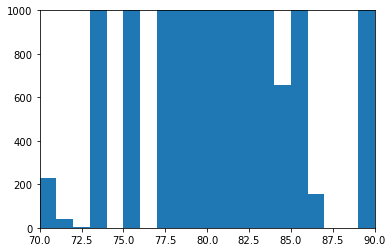

In [108]:
import matplotlib.pyplot as plt
data_merged_selected = data_merged.reset_index(drop=True)
plt.hist(data_merged_selected.Load, bins = range(0,100), weights=data_merged_selected.OrchestrationEvents)
plt.xlim(70,90)
plt.ylim(0, 1000)

In [2]:
from autoscalingsim.simevaluator.evaluation_framework import SimulationQualityEvaluationFramework

sqef = SimulationQualityEvaluationFramework('experiments/testevaluation/evaluator_conf.json')
sqef.create_simulations()
sqef.simulate()
sqef.build_figures('D:/AutoscalingSim/results/test')

Evaluation run 1 out of 2, please wait for all the simulations to finish...


  2%|█▊                                                                            | 144/6000 [00:00<00:08, 683.67it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.020000
min_time_to_subtract: 0 days 00:00:00.010000
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.030000
min_time_to_subtract: 0 days 00:00:00.010000
req.cumulative_time: 0 days 00:00:00.040000
min_time_to_subtract: 0 days 00:00:00.010000
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.040000
min_time_to_subtract: 0 days 00:00:00.010000
req.cumulative_time: 0 days 00:00:00.050000
min_time_to_subtract: 0 da

  5%|███▉                                                                          | 303/6000 [00:00<00:07, 731.92it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

  8%|█████▉                                                                        | 460/6000 [00:00<00:07, 757.05it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 10%|███████▉                                                                      | 608/6000 [00:00<00:07, 730.62it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 13%|█████████▉                                                                    | 768/6000 [00:01<00:06, 759.70it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 15%|███████████▉                                                                  | 922/6000 [00:01<00:06, 729.57it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 18%|█████████████▋                                                               | 1070/6000 [00:01<00:06, 721.88it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 19%|██████████████▋                                                              | 1143/6000 [00:01<00:07, 686.08it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 22%|████████████████▋                                                            | 1300/6000 [00:01<00:06, 728.32it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 24%|██████████████████▋                                                          | 1452/6000 [00:01<00:06, 730.72it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 27%|████████████████████▌                                                        | 1604/6000 [00:02<00:06, 709.65it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 29%|██████████████████████▋                                                      | 1764/6000 [00:02<00:05, 731.25it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 32%|████████████████████████▌                                                    | 1917/6000 [00:02<00:05, 725.12it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 34%|██████████████████████████▍                                                  | 2064/6000 [00:02<00:05, 673.40it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 37%|████████████████████████████▌                                                | 2224/6000 [00:03<00:05, 729.16it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 40%|██████████████████████████████▋                                              | 2389/6000 [00:03<00:04, 772.31it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 43%|████████████████████████████████▊                                            | 2554/6000 [00:03<00:04, 789.62it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 45%|██████████████████████████████████▊                                          | 2710/6000 [00:03<00:04, 734.64it/s]

min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subt

 48%|████████████████████████████████████▉                                        | 2874/6000 [00:03<00:04, 746.96it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 49%|█████████████████████████████████████▊                                       | 2950/6000 [00:03<00:04, 749.26it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 51%|███████████████████████████████████████▌                                     | 3086/6000 [00:04<00:06, 446.27it/s]


temp_change: {'db': 0}
containers_count_to_consider: 1
soft_adjustment_internal
temp_change: {}
containers_count_to_consider: 1
soft_adjustment_internal
temp_change: {}
containers_count_to_consider: 1
ep
14
ep
14
ep
14
ep
14
ep
15
ep
15
ep
15
ep
15
ep
14
ep
14
ep
14
ep
14
ep
14
ep
15
ep
15
ep
15
ep
15
ep
14
ep
14
ep
14
ep
14
ep
14
ep
14
ep
15
ep
15
ep
15
ep
15
ep
14
ep
14
ep
14
ep
14
ep
14
ep
14
ep
14
ep
15
ep
15
ep
15
ep
15
ep
14
ep
14
ep
14
ep
14
ep11
14
{'db': 1, 'appserver': 1, 'frontend': 1}
ep11
14
{'db': 1, 'appserver': 1, 'frontend': 1}
ep11
14
{'db': 1, 'appserver': 3, 'frontend': 3}
ep11
14
{'db': 1, 'appserver': 7, 'frontend': 7}
ep11
15
{'db': 1, 'appserver': 1, 'frontend': 1}
ep11
15
{'db': 1, 'appserver': 1, 'frontend': 1}
ep11
15
{'db': 1, 'appserver': 3, 'frontend': 3}
ep11
15
{'db': 1, 'appserver': 7, 'frontend': 7}
ep11
14
{'db': 1, 'appserver': 1, 'frontend': 1}
ep11
14
{'db': 1, 'appserver': 2, 'frontend': 2}
ep11
14
{'db': 1, 'appserver': 4, 'frontend': 4}
ep11
14

 52%|████████████████████████████████████████▎                                    | 3141/6000 [00:04<00:06, 442.08it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 53%|████████████████████████████████████████▉                                    | 3193/6000 [00:04<00:07, 392.15it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 55%|██████████████████████████████████████████▋                                  | 3327/6000 [00:05<00:06, 405.98it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 57%|███████████████████████████████████████████▊                                 | 3412/6000 [00:05<00:06, 404.56it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 59%|█████████████████████████████████████████████▍                               | 3538/6000 [00:05<00:06, 403.17it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 60%|██████████████████████████████████████████████▍                              | 3619/6000 [00:05<00:06, 378.56it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 62%|███████████████████████████████████████████████▍                             | 3697/6000 [00:06<00:06, 374.51it/s]

min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subt

 64%|█████████████████████████████████████████████████                            | 3819/6000 [00:06<00:05, 391.20it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 64%|█████████████████████████████████████████████████▌                           | 3859/6000 [00:06<00:05, 388.87it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 66%|██████████████████████████████████████████████████▌                          | 3940/6000 [00:06<00:05, 392.47it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 67%|███████████████████████████████████████████████████▌                         | 4022/6000 [00:06<00:05, 351.92it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 68%|████████████████████████████████████████████████████▋                        | 4106/6000 [00:07<00:04, 381.20it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 70%|██████████████████████████████████████████████████████▎                      | 4229/6000 [00:07<00:04, 394.71it/s]

req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_t

 72%|███████████████████████████████████████████████████████▎                     | 4309/6000 [00:07<00:04, 386.91it/s]


req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_

 73%|████████████████████████████████████████████████████████▎                    | 4390/6000 [00:07<00:04, 373.11it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 75%|█████████████████████████████████████████████████████████▊                   | 4508/6000 [00:08<00:03, 382.51it/s]


min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_subtract: 0 days 00:00:00
req.cumulative_time: 0 days 00:00:00.010000
min_time_to_sub

 76%|██████████████████████████████████████████████████████████▏                  | 4531/6000 [00:08<00:02, 553.08it/s]


KeyboardInterrupt: 

In [23]:
# To profile:
# python -m cProfile -o D:\AutoscalingSim\results\profiling_res.txt autoscalingsim-cl.py --step 10 --start "2020-09-17T10:00:00" --confdir "experiments/test" --simtime 1m
import pstats
from pstats import SortKey
p = pstats.Stats('D://AutoscalingSim//results//profiling_res.txt')
p.strip_dirs().sort_stats(SortKey.CALLS).print_stats()

Sat Nov 14 14:33:57 2020    D://AutoscalingSim//results//profiling_res.txt

         2872959 function calls (2855879 primitive calls) in 6.027 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   233486    0.029    0.000    0.029    0.000 {method 'items' of 'dict' objects}
186734/180680    0.029    0.000    0.032    0.000 {built-in method builtins.len}
   184282    0.038    0.000    0.055    0.000 {built-in method builtins.isinstance}
   147266    0.288    0.000    0.393    0.000 system_capacity.py:20(__init__)
   147266    0.043    0.000    0.043    0.000 node.py:43(get_unique_id)
   147266    0.062    0.000    0.062    0.000 node.py:49(get_capacity)
    79082    0.012    0.000    0.012    0.000 {method 'values' of 'dict' objects}
    71928    0.033    0.000    0.067    0.000 requests_buffer.py:88(size)
    71928    0.025    0.000    0.034    0.000 discipline.py:121(size)
    60793    0.010    0.000    0.010    0.000 {built-in 

      422    0.000    0.000    0.001    0.000 common.py:685(is_dtype_equal)
      420    0.000    0.000    0.000    0.000 {built-in method builtins.chr}
      419    0.003    0.000    0.008    0.000 blocks.py:343(ftype)
      416    0.001    0.000    0.002    0.000 base.py:472(_simple_new)
      414    0.001    0.000    0.005    0.000 common.py:219(asarray_tuplesafe)
      408    0.001    0.000    0.001    0.000 generic.py:5235(__finalize__)
    408/5    0.001    0.000    0.850    0.170 {built-in method builtins.__import__}
      397    0.000    0.000    0.000    0.000 {built-in method numpy.seterrobj}
      396    0.001    0.000    0.003    0.000 _ufunc_config.py:39(seterr)
      396    0.001    0.000    0.001    0.000 _ufunc_config.py:139(geterr)
      395    0.007    0.000    0.017    0.000 managers.py:212(_rebuild_blknos_and_blklocs)
      393    0.000    0.000    0.002    0.000 managers.py:943(_consolidate_inplace)
      392    0.000    0.000    0.004    0.000 common.py:1647(_is_d

      135    0.000    0.000    0.000    0.000 six.py:88(__init__)
      133    0.000    0.000    0.000    0.000 __init__.py:388(<genexpr>)
      133    0.000    0.000    0.001    0.000 common.py:1108(is_datetime_or_timedelta_dtype)
      132    0.000    0.000    0.000    0.000 _dtype.py:190(_datetime_metadata_str)
      132    0.000    0.000    0.000    0.000 {built-in method numpy.datetime_data}
      131    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
      129    0.001    0.000    0.008    0.000 missing.py:225(_isna_ndarraylike)
      129    0.000    0.000    0.001    0.000 frequencies.py:74(to_offset)
      129    0.000    0.000    0.000    0.000 managers.py:1032(<genexpr>)
      126    0.000    0.000    0.000    0.000 sre_compile.py:65(_combine_flags)
      126    0.000    0.000    0.000    0.000 nanops.py:55(check)
      126    0.000    0.000    0.000    0.000 format.py:394(len)
      126    0.000    0.000    0.000    0.000 expr.py:168(<genexpr>)
      126    

       63    0.003    0.000    0.021    0.000 managers.py:998(delete)
       63    0.000    0.000    0.000    0.000 concat.py:384(<genexpr>)
       63    0.000    0.000    0.000    0.000 format.py:397(justify)
       63    0.000    0.000    0.000    0.000 format.py:1744(<genexpr>)
       63    0.000    0.000    0.000    0.000 series.py:844(_ixs)
       63    0.001    0.000    0.002    0.000 {method 'add' of 'pandas._libs.internals.BlockPlacement' objects}
       63    0.000    0.000    0.000    0.000 {method 'clear_mapping' of 'pandas._libs.index.IndexEngine' objects}
       63    0.001    0.000    0.001    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
       63    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
       62    0.000    0.000    0.000    0.000 lazy.py:96(lazy)
       62    0.000    0.000    0.000    0.000 __init__.py:246(_get_opstr)
       61    0.000    0.000    0.000    0.000 sre_parse.py:224(__init__)
       61    0.000    0.000    0.023    0.000 ma

       31    0.000    0.000    0.000    0.000 entities_states_reg.py:9(__init__)
       30    0.000    0.000    0.000    0.000 _type_aliases.py:238(_add_array_type)
       30    0.000    0.000    0.000    0.000 getlimits.py:19(_fr0)
       30    0.000    0.000    0.000    0.000 getlimits.py:27(_fr1)
       30    0.000    0.000    0.000    0.000 getlimits.py:42(<lambda>)
       30    0.000    0.000    0.000    0.000 getlimits.py:43(<lambda>)
       30    0.000    0.000    0.000    0.000 __init__.py:101(get_op_result_name)
       30    0.000    0.000    0.000    0.000 __init__.py:124(_maybe_match_name)
       30    0.001    0.000    0.018    0.001 dispatch.py:48(should_series_dispatch)
       30    0.000    0.000    0.000    0.000 base.py:697(astype)
       30    0.000    0.000    0.000    0.000 base.py:2159(_get_reconciled_name_object)
       30    0.000    0.000    0.000    0.000 base.py:2194(_is_compatible_with_other)
    30/15    0.000    0.000    0.027    0.002 base.py:2217(union)
 

       21    0.000    0.000    0.010    0.000 concat.py:513(_get_new_axes)
       21    0.000    0.000    0.002    0.000 concat.py:520(_get_comb_axis)
       21    0.000    0.000    0.000    0.000 concat.py:559(<listcomp>)
       21    0.000    0.000    0.007    0.000 concat.py:526(_get_concat_axis)
       21    0.000    0.000    0.000    0.000 concat.py:576(_maybe_check_integrity)
       21    0.000    0.000    0.007    0.000 concat.py:586(_concat_indexes)
       21    0.000    0.000    0.011    0.001 count.py:45(__mul__)
       21    0.000    0.000    0.000    0.000 {built-in method _operator.invert}
       21    0.003    0.000    0.003    0.000 {built-in method nt.get_terminal_size}
       21    0.000    0.000    0.000    0.000 {method 'getvalue' of '_io.StringIO' objects}
       21    0.000    0.000    0.000    0.000 {method 'write' of '_io.StringIO' objects}
       21    0.000    0.000    0.000    0.000 {method 'fileno' of '_io.TextIOWrapper' objects}
       21    0.000    0.000  

       10    0.000    0.000    0.000    0.000 {method 'find' of 'str' objects}
        9    0.000    0.000    0.000    0.000 enum.py:901(<lambda>)
        9    0.000    0.000    0.903    0.100 __init__.py:3(<module>)
        9    0.000    0.000    0.000    0.000 _globals.py:77(__repr__)
        9    0.000    0.000    0.000    0.000 multiarray.py:312(where)
        9    0.000    0.000    0.000    0.000 datetime.py:473(__new__)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(where)
        9    0.000    0.000    0.000    0.000 shape_base.py:79(_atleast_2d_dispatcher)
        9    0.000    0.000    0.000    0.000 shape_base.py:83(atleast_2d)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        9    0.000    0.000    0.000    0.000 _pytesttester.py:77(__init__)
        9    0.000    0.000    0.000    0.000 inspect.py:72(isclass)
        9    0.000    0.000    0.000    0.000 base.py:2906(_convert_slice_indexer)
   

        6    0.000    0.000    0.000    0.000 container_group.py:135(extract_scaling_aspects)
        6    0.000    0.000    0.000    0.000 system_capacity.py:173(collapse)
        6    0.000    0.000    0.000    0.000 node.py:77(entities_require_capacity)
        6    0.000    0.000    0.000    0.000 container_group_set.py:61(_add_groups)
        6    0.000    0.000    0.000    0.000 entities_states_reg.py:146(__sub__)
        6    0.000    0.000    0.000    0.000 entities_states_reg.py:151(_add)
        6    0.000    0.000    0.000    0.000 entities_states_reg.py:170(copy)
        6    0.000    0.000    0.000    0.000 entities_states_reg.py:174(extract_raw_scaling_aspects_changes)
        6    0.000    0.000    0.000    0.000 statemanagers.py:21(add_source)
        6    0.000    0.000    0.016    0.003 limiter.py:43(_min_comparison)
        6    0.000    0.000    0.016    0.003 limiter.py:59(_max_comparison)
        6    0.000    0.000    0.000    0.000 service_state.py:454(force_rem

        3    0.000    0.000    0.000    0.000 datetimes.py:2106(_maybe_normalize_endpoints)
        3    0.000    0.000    0.021    0.007 datetimes.py:1(<module>)
        3    0.000    0.000    0.000    0.000 datetimelike.py:484(__array__)
        3    0.000    0.000    0.000    0.000 datetimelike.py:714(copy)
        3    0.000    0.000    0.000    0.000 datetimelike.py:1596(validate_periods)
        3    0.000    0.000    0.000    0.000 datetimelike.py:1622(validate_endpoints)
        3    0.000    0.000    0.000    0.000 offsets.py:2580(__eq__)
        3    0.000    0.000    0.000    0.000 offsets.py:2619(delta)
        3    0.000    0.000    0.000    0.000 offsets.py:2623(nanos)
        3    0.000    0.000    0.000    0.000 _ranges.py:15(generate_regular_range)
        3    0.000    0.000    0.000    0.000 base.py:1682(is_categorical)
        3    0.000    0.000    0.000    0.000 base.py:4963(delete)
        3    0.000    0.000    0.001    0.000 base.py:4993(drop)
        3    0.00

        2    0.000    0.000    0.000    0.000 delta_timeline.py:17(__init__)
        2    0.000    0.000    0.000    0.000 combiners.py:33(decorator)
        2    0.000    0.000    0.000    0.000 combiners.py:29(register)
        2    0.000    0.000    0.000    0.000 combiners.py:102(<dictcomp>)
        2    0.000    0.000    0.000    0.000 combiners.py:108(<lambda>)
        2    0.000    0.000    0.000    0.000 requests_buffer.py:58(take)
        2    0.000    0.000    0.000    0.000 load_stats.py:15(add_request)
        2    0.000    0.000    0.000    0.000 load_stats.py:47(add_request)
        2    0.000    0.000    0.000    0.000 std.py:112(create_th_lock)
        2    0.000    0.000    0.000    0.000 std.py:1091(_comparable)
        2    0.000    0.000    0.000    0.000 std.py:1095(__hash__)
        2    0.000    0.000    0.000    0.000 std.py:1277(fp_write)
        2    0.000    0.000    0.001    0.000 std.py:1260(close)
        2    0.000    0.000    0.000    0.000 initialise.py

        1    0.000    0.000    0.000    0.000 datetime.py:1162(time)
        1    0.000    0.000    0.000    0.000 datetime.py:1509(datetime)
        1    0.000    0.000    0.000    0.000 datetime.py:2136(timezone)
        1    0.000    0.000    0.001    0.001 datetime.py:5(<module>)
        1    0.000    0.000    0.016    0.016 __init__.py:10(<module>)
        1    0.000    0.000    0.000    0.000 _inspect.py:7(<module>)
        1    0.000    0.000    0.000    0.000 py3k.py:116(contextlib_nullcontext)
        1    0.000    0.000    0.014    0.014 py3k.py:12(<module>)
        1    0.000    0.000    0.000    0.000 pathlib.py:55(_Flavour)
        1    0.000    0.000    0.000    0.000 pathlib.py:134(<setcomp>)
        1    0.000    0.000    0.000    0.000 pathlib.py:135(<setcomp>)
        1    0.000    0.000    0.000    0.000 pathlib.py:118(_WindowsFlavour)
        1    0.000    0.000    0.000    0.000 pathlib.py:282(_PosixFlavour)
        1    0.000    0.000    0.000    0.000 pathlib.py:

        1    0.000    0.000    0.000    0.000 index_tricks.py:684(IndexExpression)
        1    0.000    0.000    0.023    0.023 index_tricks.py:1(<module>)
        1    0.000    0.000    0.000    0.000 defmatrix.py:74(matrix)
        1    0.000    0.000    0.013    0.013 defmatrix.py:1(<module>)
        1    0.000    0.000    0.000    0.000 ast.py:238(NodeVisitor)
        1    0.000    0.000    0.000    0.000 ast.py:275(NodeTransformer)
        1    0.000    0.000    0.000    0.000 ast.py:26(<module>)
        1    0.000    0.000    0.010    0.010 __init__.py:71(<module>)
        1    0.000    0.000    0.000    0.000 linalg.py:52(LinAlgError)
        1    0.001    0.001    0.001    0.001 linalg.py:82(_determine_error_states)
        1    0.000    0.000    0.009    0.009 linalg.py:10(<module>)
        1    0.000    0.000    0.001    0.001 twodim_base.py:3(<module>)
        1    0.000    0.000    0.000    0.000 function_base.py:1878(vectorize)
        1    0.000    0.000    0.000    0.00

        1    0.000    0.000    0.001    0.001 config_init.py:11(<module>)
        1    0.000    0.000    0.000    0.000 dtypes.py:61(__init__)
        1    0.000    0.000    0.000    0.000 dtypes.py:45(Registry)
        1    0.000    0.000    0.000    0.000 dtypes.py:108(PandasExtensionDtype)
        1    0.000    0.000    0.000    0.000 dtypes.py:156(CategoricalDtypeType)
        1    0.000    0.000    0.000    0.000 dtypes.py:221(__init__)
        1    0.000    0.000    0.000    0.000 dtypes.py:363(_finalize)
        1    0.000    0.000    0.000    0.000 dtypes.py:497(validate_ordered)
        1    0.000    0.000    0.000    0.000 dtypes.py:164(CategoricalDtype)
        1    0.000    0.000    0.000    0.000 dtypes.py:609(DatetimeTZDtype)
        1    0.000    0.000    0.000    0.000 dtypes.py:780(PeriodDtype)
        1    0.000    0.000    0.000    0.000 dtypes.py:973(IntervalDtype)
        1    0.000    0.000    0.013    0.013 dtypes.py:1(<module>)
        1    0.000    0.000    0.0

        1    0.000    0.000    0.000    0.000 offsets.py:1311(SemiMonthOffset)
        1    0.000    0.000    0.000    0.000 offsets.py:1417(SemiMonthEnd)
        1    0.000    0.000    0.000    0.000 offsets.py:1476(SemiMonthBegin)
        1    0.000    0.000    0.000    0.000 offsets.py:1536(Week)
        1    0.000    0.000    0.000    0.000 offsets.py:1659(_WeekOfMonthMixin)
        1    0.000    0.000    0.000    0.000 offsets.py:1684(WeekOfMonth)
        1    0.000    0.000    0.000    0.000 offsets.py:1754(LastWeekOfMonth)
        1    0.000    0.000    0.000    0.000 offsets.py:1825(QuarterOffset)
        1    0.000    0.000    0.000    0.000 offsets.py:1895(BQuarterEnd)
        1    0.000    0.000    0.000    0.000 offsets.py:1912(BQuarterBegin)
        1    0.000    0.000    0.000    0.000 offsets.py:1921(QuarterEnd)
        1    0.000    0.000    0.000    0.000 offsets.py:1936(QuarterBegin)
        1    0.000    0.000    0.000    0.000 offsets.py:1948(YearOffset)
        1  

        1    0.000    0.000    0.000    0.000 groupby.py:1336(_add_numeric_operations)
        1    0.000    0.000    0.001    0.001 groupby.py:1035(GroupBy)
        1    0.000    0.000    0.010    0.010 groupby.py:8(<module>)
        1    0.000    0.000    0.000    0.000 ops.py:59(BaseGrouper)
        1    0.000    0.000    0.000    0.000 ops.py:700(BinGrouper)
        1    0.000    0.000    0.000    0.000 ops.py:881(DataSplitter)
        1    0.000    0.000    0.000    0.000 ops.py:920(SeriesSplitter)
        1    0.000    0.000    0.000    0.000 ops.py:925(FrameSplitter)
        1    0.000    0.000    0.004    0.004 ops.py:7(<module>)
        1    0.000    0.000    0.000    0.000 grouper.py:35(Grouper)
        1    0.000    0.000    0.000    0.000 grouper.py:218(Grouping)
        1    0.000    0.000    0.001    0.001 grouper.py:4(<module>)
        1    0.000    0.000    0.010    0.010 eval.py:5(<module>)
        1    0.000    0.000    0.000    0.000 engines.py:16(NumExprClobberingEr

        1    0.000    0.000    0.002    0.002 container_group_set.py:1(<module>)
        1    0.000    0.000    0.000    0.000 regional_delta.py:37(get_container_groups_ids_for_removal)
        1    0.000    0.000    0.001    0.001 regional_delta.py:80(enforce)
        1    0.000    0.000    0.000    0.000 regional_delta.py:6(RegionalDelta)
        1    0.000    0.000    0.000    0.000 regional_delta.py:103(RegionalDeltaIterator)
        1    0.000    0.000    0.000    0.000 regional_delta.py:1(<module>)
        1    0.000    0.000    0.000    0.000 entities_states_reg.py:3(EntitiesStatesRegionalized)
        1    0.000    0.000    0.000    0.000 entities_states_reg.py:103(EntitiesStatesIterator)
        1    0.000    0.000    0.000    0.000 entities_states_reg.py:125(EntitiesStatesRegionalizedDelta)
        1    0.000    0.000    0.000    0.000 entities_states_reg.py:1(<module>)
        1    0.000    0.000    0.000    0.000 platform_state_delta.py:55(get_container_groups_ids_for_remov

        1    0.000    0.000    0.000    0.000 __init__.py:420(PercentStyle)
        1    0.000    0.000    0.000    0.000 __init__.py:435(StrFormatStyle)
        1    0.000    0.000    0.000    0.000 __init__.py:444(StringTemplateStyle)
        1    0.000    0.000    0.000    0.000 __init__.py:513(__init__)
        1    0.000    0.000    0.000    0.000 __init__.py:468(Formatter)
        1    0.000    0.000    0.000    0.000 __init__.py:643(BufferingFormatter)
        1    0.000    0.000    0.000    0.000 __init__.py:685(Filter)
        1    0.000    0.000    0.000    0.000 __init__.py:722(Filterer)
        1    0.000    0.000    0.000    0.000 __init__.py:794(_addHandlerRef)
        1    0.000    0.000    0.000    0.000 __init__.py:813(__init__)
        1    0.000    0.000    0.000    0.000 __init__.py:842(createLock)
        1    0.000    0.000    0.000    0.000 __init__.py:804(Handler)
        1    0.000    0.000    0.000    0.000 __init__.py:991(StreamHandler)
        1    0.000    